# PL610-Borowiec normal vectors and station map

The first order of business is to read the CSV file containing the ETRS89 measurements of the surface of the Borowiecstation.

In [2]:
%pylab inline
import csv

def read_etrs_csv(csv_name, delimiter=','):
    with open(csv_name, 'r') as csv_file:
        csv_rows = [(row[0], array([float(num) for num in row[1:4]])) 
                    for row in csv.reader(csv_file, delimiter=delimiter)
                    if 'ETRS' not in row[1]]
    names = [row[0] for row in csv_rows]
    positions = array([row[1] for row in csv_rows])
    return names, positions

all_names, all_positions = read_etrs_csv('Borowiec-points_in_ECEF.txt')
field_corners_names, field_corners_etrs = read_etrs_csv('pl610-borowiec-field-corners.csv')
container_names, container_etrs = read_etrs_csv('pl610-borowiec-container.csv')
reference_names, reference_etrs = read_etrs_csv('pl610-borowiec-reference-points.csv')

Populating the interactive namespace from numpy and matplotlib


It seems like we succeeded in reading the file. The variable *position_dict* can be used to look up positions based on the name of the point. *all_positions* is an array of all 3D ETRS coordinates, and *all_names* holds the corresponding names.

In [3]:
mean_position = all_positions.mean(axis=0)
print('Mean position (ETRS89): ', mean_position)

Mean position (ETRS89):  [ 3738444.82982051  1148221.30607692  5021729.04588461]


And in geographic coordinates in radians and meters:

In [4]:
from lofargeo import *
geo_mean = geographic_from_xyz(mean_position)
print('''lat_rad : %(lat_rad).10f rad
lon_rad : %(lon_rad).10f rad
height_m: %(height_m).3f m''' % geo_mean)

print(geo_mean['lat_rad']*180/pi)
print(geo_mean['lon_rad']*180/pi)

lat_rad : 0.9123847183 rad
lon_rad : 0.2979931788 rad
height_m: 114.835 m
52.2757936515
17.0737514711


The normal vector to the WGS84 ellipsoid is then

In [5]:
ellipsoid_normal = normal_vector_ellipsoid(geo_mean['lon_rad'], geo_mean['lat_rad'])
repr(ellipsoid_normal)

'array([ 0.58489508,  0.17964395,  0.7909651 ])'

## Slope of the field and selection of subset of points

The first inspection of the data is done with respect to the plane parallel to the tangent plane of the WGS84 ellipsoid at the mean position of all measured points, that goes right through the mean coordinate of all measured points. We determine a transformation_matrix that ensures that transformed "x" will be pointing east, "y" towards geographic north, and "z" up and perpendicular to the tangent plane of the ellipsoid at the longitude and latitude of the mean position.

In [6]:
local_north_projection = projection_matrix(mean_position, ellipsoid_normal)
local_north_xyz = transform(all_positions, mean_position, local_north_projection.T)

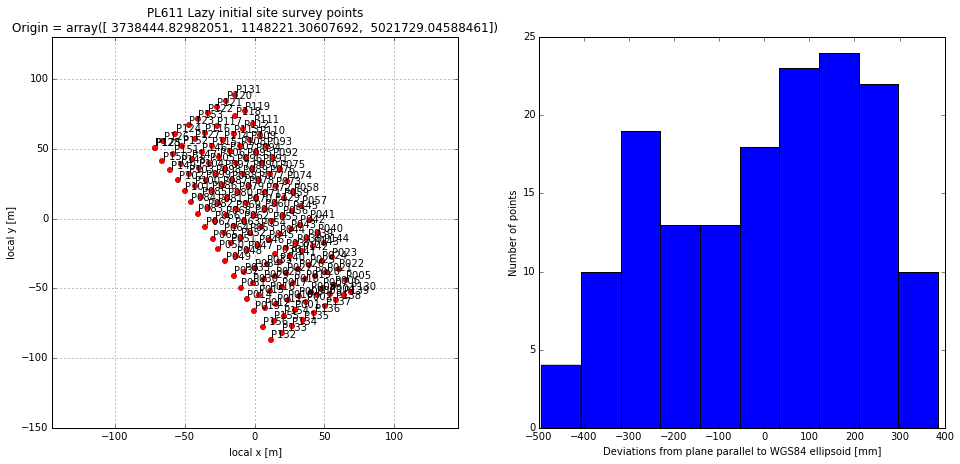

In [7]:
figure(figsize=(16,7))
subplot(121)
scatter(local_north_xyz[:,0], local_north_xyz[:,1])
for name, offset in zip(all_names, local_north_xyz):
    text(offset[0]+1, offset[1]+1
         , name)
axis('equal')
grid()
ylim(-150, +130)

title('PL611 Lazy initial site survey points\nOrigin = %r' %
      mean_position)
xlabel('local x [m]')
ylabel('local y [m]')

max_y = 500.0
min_y = -500.0
min_x = -500.0
max_x = +500.0
selection_xyz = array([xyz for xyz in local_north_xyz
                      if xyz[0] > min_x and xyz[0] < max_x 
                      and xyz[1]> min_y and xyz[1] < max_y])
selection_etrs = array([etrs for etrs, xyz in zip(all_positions, local_north_xyz)
                      if xyz[0] > min_x and xyz[0] < max_x
                      and xyz[1]> min_y and xyz[1] < max_y])
scatter(selection_xyz[:,0], selection_xyz[:,1], color='red')

subplot(122)
hist(1000*selection_xyz[:,2], bins=10)
xlabel('Deviations from plane parallel to WGS84 ellipsoid [mm]')
ylabel('Number of points')

The red points (the ones in the *selection_xyz* and *selection_etrs* variables) are used to fit the best fit plane to the station. *The histogram clearly shows that these points are not actual measurements*!

In [8]:
print ('The selection contains %d points.' % len(selection_etrs))

The selection contains 156 points.


The following function interpolates between unstructured points in 3D space.

In [9]:
from scipy.interpolate import Rbf # Radial basis function interpolation.
def interpolation_function(pqr):
    '''
    Return an interpolation function fn(x, y, z), which returns the value at x, y, 0.
    Make sure to pass an array of zeros the same shape as the x and y arrays.
    '''
    rbfi = Rbf(pqr[:,0], pqr[:,1], 0.0*pqr[:,2], pqr[:,2], function='linear')
    return rbfi

In [10]:
xyz_interpol_fn = interpolation_function(selection_xyz)
x_m, y_m = meshgrid(arange(-120, 150), arange(-100,100))
z_m = xyz_interpol_fn(x_m, y_m, 0.0*y_m)

Now let's plot a map of elevation of the selection relative to the mean position of all points.

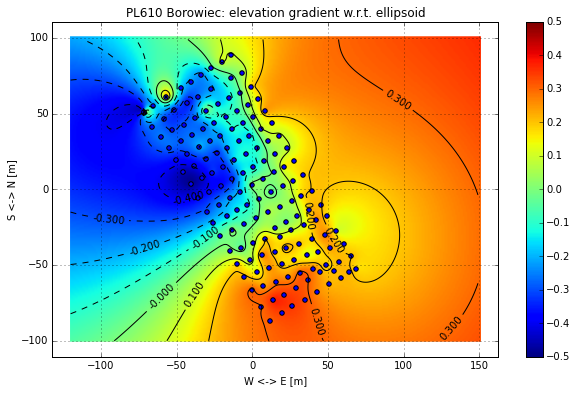

In [11]:
figure(figsize=(10,6))
imshow(z_m, origin='lower', vmin=-0.5, vmax=0.5, extent=(-120.5, 150.5, -100.5, 100.5))
colorbar()
cnt = contour(x_m, y_m, z_m, levels=arange(-0.50, 2.0, 0.10), colors='black')
cnt.clabel(inline=True)
xlabel('W <-> E [m]')
ylabel('S <-> N [m]')
axis('equal')
grid()
title('PL610 Borowiec: elevation gradient w.r.t. ellipsoid')
scatter(selection_xyz[:,0], selection_xyz[:,1])


## Best fit plane and deviations from that plane

In [12]:
from numpy.linalg import lstsq

def fit_plane(xyz):
    # data_model z = ax +by +c
    # M colvec(a, b, c) = colvec(z)
    # M row i = (x_i, y_i, 1.0)
    mean_position = xyz.mean(axis=0)
    mat = array([xyz[:,0]- mean_position[0],
                 xyz[:,1]- mean_position[1],
                 ones(len(xyz[:,2]))]).T
    a, b, c = lstsq(mat, xyz[:,2] - mean_position[2])[0]
    normal_vector = array([-a, -b, 1.0])
    normal_vector /= norm(normal_vector)
    return {'mean': mean_position, 'normal': normal_vector}

In [13]:
solution = fit_plane(selection_etrs)
rotation_matrix = projection_matrix(LOFAR_XYZ0_m, solution['normal'])
print('Normal vector: ', repr(solution['normal']))
print('Mean position: ', repr(solution['mean']))
print('Rotation matrix:\n', repr(rotation_matrix))

CHBA_ETRS = field_corners_etrs[4:8,:].mean(axis=0)
CHBA_ETRS = array([3738464.820, 1148245.533, 5021708.895])
CLBA_ETRS = field_corners_etrs[0:4,:].mean(axis=0)
CLBA_ETRS = array([3738426.421, 1148186.809, 5021750.297])

Normal vector:  array([ 0.58564834,  0.17503803,  0.79144028])
Mean position:  array([ 3738444.82982051,  1148221.30607692,  5021729.04588461])
Rotation matrix:
 array([[-0.18134509, -0.79001898,  0.58564834],
       [ 0.9799497 , -0.09518548,  0.17503803],
       [-0.08253814,  0.6056482 ,  0.79144028]])


In [14]:
station_pqr = transform(selection_etrs, CLBA_ETRS, rotation_matrix.T)
station_height_deviation_fn = interpolation_function(station_pqr)
print('p range: ', station_pqr[:,0].min(),'--', station_pqr[:,0].max())
print('q range: ', station_pqr[:,1].min(),'--', station_pqr[:,1].max())

p range:  -46.0503503694 -- 107.690458422
q range:  -115.002534219 -- 55.1212440741


In [15]:
p_m, q_m = meshgrid(arange(-50, 120), arange(-120, 60))
r_m = station_height_deviation_fn(p_m, q_m, 0.0*q_m)

def square_corners(width, angle_rad=0.0):
    rot_mat = array([[cos(angle_rad), -sin(angle_rad)],
                     [sin(angle_rad), cos(angle_rad)]])
    corners = array([[-1, 1.0],[1.0, 1.0],[1.0, -1.0],[-1.0, -1.0],[-1.0, 1.0]])*width/2.0
    return array([dot(rot_mat, point) for point in corners])
HBA_CIRCLE_DIAMETER = 62.0
LBA_CIRCLE_DIAMETER = 75.0

def circle_points(diameter_m, num_points=100):
    phases = arange(0.0, 2*pi+2*pi/(2*num_points), 2*pi/(num_points-1))
    x = cos(phases)*diameter_m/2.0
    y = sin(phases)*diameter_m/2.0
    return concatenate([x.reshape((num_points, 1)), y.reshape((num_points, 1))], axis=1)
#CHBA_ETRS = array([3727219.85688834, 655104.69624212, 5117002.01149518]) # See below
#CLBA_estimate = array([ 3727210.72339844,   655184.53745788,  5117000.60903704])
#CLBA_ETRS = CHBA_ETRS + \
#    (CLBA_estimate - CHBA_ETRS)*78.5/norm(CLBA_estimate - CHBA_ETRS)

[[ -5.27881482e+01   5.11098597e+00   5.32579552e-01]
 [  5.10947485e+00   5.27898937e+01   2.67388999e-01]
 [  5.27876495e+01  -5.10894264e+00   3.69154666e-02]
 [ -5.10929011e+00  -5.27921326e+01   3.01663682e-01]
 [ -5.27881482e+01   5.11098597e+00   5.32579552e-01]]
[ 0.  0.  0.]
[  5.40003401e+01  -6.10006578e+01   3.32400028e-05]
[  5.40003401e+01  -6.10006578e+01   3.32400028e-05]
[[ 3738464.81952255  1148245.53259829  5021708.89540015]]
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  5.40003401e+01  -6.10006578e+01   3.32400028e-05]]
CONTAINER (P, Q):
                    N: (53.424, -5.880),
                    E: (58.510, -12.057),
                    S: (56.193, -13.964),
                    W: (51.107, -7.788))


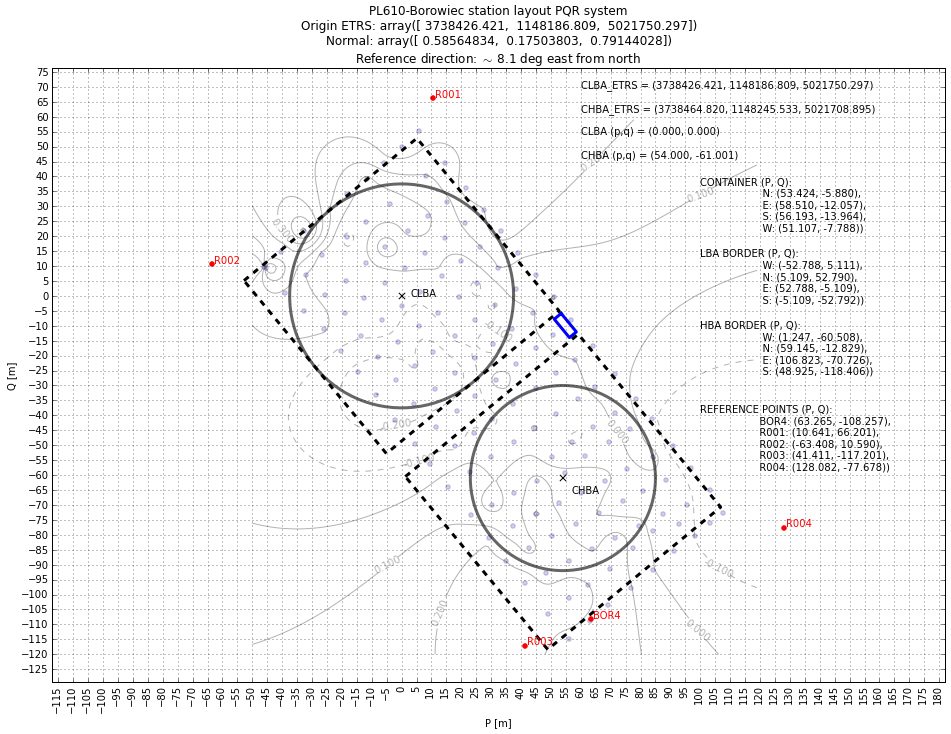

In [16]:
from functools import reduce

figure(figsize=(16, 11))
axis('equal')
grid()
cnt = contour(p_m, q_m, r_m, levels=arange(-2.0, 2.0, 0.1), colors='black', alpha=0.3)
cnt.clabel(inline=True)

xlabel('P [m]')
ylabel('Q [m]')
xticks(arange(-200, 200, 5), rotation=90)
yticks(arange(-200, 200, 5))

scatter(station_pqr[:,0], station_pqr[:,1], alpha=0.2)

lba_box_width_m = 85.0
hba_box_width_m = 72

container_pqr = transform(container_etrs, CLBA_ETRS, rotation_matrix.T)
container_pqr = concatenate([container_pqr, container_pqr[0,:].reshape((1,3))], axis=0)
lba_border_pqr = transform(field_corners_etrs[0:4,:], CLBA_ETRS, rotation_matrix.T)
lba_border_pqr =  concatenate([lba_border_pqr, lba_border_pqr[0,:].reshape((1,3))], axis=0)
hba_border_pqr = transform(field_corners_etrs[4:8,:], CLBA_ETRS, rotation_matrix.T)
hba_border_pqr =  concatenate([hba_border_pqr, hba_border_pqr[0,:].reshape((1,3))], axis=0)
reference_pqr =  transform(reference_etrs, CLBA_ETRS, rotation_matrix.T)

print(lba_border_pqr)
plot(container_pqr[:,0], container_pqr[:,1], linewidth=3)
plot(lba_border_pqr[:,0], lba_border_pqr[:,1], linewidth=3, color='black', linestyle='--')
plot(hba_border_pqr[:,0], hba_border_pqr[:,1], linewidth=3, color='black', linestyle='--')

for name, pqr in zip(reference_names, reference_pqr):
    scatter(pqr[0], pqr[1], color='red')
    text(pqr[0]+1, pqr[1]+0.5, name, color='red')

#lba_square = square_corners(lba_box_width_m, angle_rad=rot_ccw_rad)
#hba_square = square_corners(hba_box_width_m, angle_rad=rot_ccw_rad)


chba_pqr = transform([CHBA_ETRS], CLBA_ETRS, rotation_matrix.T)[0]
#plot(hba_square[:,0]+chba_pqr[0], hba_square[:,1]+chba_pqr[1], linewidth=3, alpha=0.6, color='black')
hba_circle = circle_points(HBA_CIRCLE_DIAMETER)
plot(hba_circle[:,0]+chba_pqr[0], hba_circle[:,1]+chba_pqr[1], linewidth=3, alpha=0.6, color='black')
clba_pqr = transform([CLBA_ETRS], CLBA_ETRS, rotation_matrix.T)[0]
#plot(lba_square[:,0]+clba_pqr[0], lba_square[:,1]+clba_pqr[1], linewidth=3, alpha=0.6, color='black')
lba_circle = circle_points(LBA_CIRCLE_DIAMETER)
plot(lba_circle[:,0]+clba_pqr[0], lba_circle[:,1]+clba_pqr[1], linewidth=3, alpha=0.6, color='black')

#CHBA_ETRS = solution['mean']+(transform([new_chba_pqr], zeros(3), rotation_matrix)[0,:])
#CLBA_ETRS = solution['mean']+(transform([new_clba_pqr], zeros(3), rotation_matrix)[0,:])

scatter(chba_pqr[0], chba_pqr[1], color='black', s=40, marker='x')
text(chba_pqr[0]+3, chba_pqr[1]-5, 'CHBA', color='black')
scatter(clba_pqr[0], clba_pqr[1], color='black', s=40, marker='x')
text(clba_pqr[0]+3, clba_pqr[1], 'CLBA', color='black')



title(r'''PL610-Borowiec station layout PQR system
Origin ETRS: %r
Normal: %r
Reference direction: $\sim$ 8.1 deg east from north''' %
      (CLBA_ETRS, solution['normal']))
print(clba_pqr)
print(chba_pqr)
print(chba_pqr - clba_pqr)
lh=8
line=0
text(60, 70-line*lh, 'CLBA_ETRS = (%.3f, %.3f, %.3f)' % (CLBA_ETRS[0], CLBA_ETRS[1], CLBA_ETRS[2]))
line+=1
text(60, 70-line*lh, 'CHBA_ETRS = (%.3f, %.3f, %.3f)' % (CHBA_ETRS[0], CHBA_ETRS[1], CHBA_ETRS[2]))
line+=1
text(60, 70-line*lh, 'CLBA (p,q) = (%.3f, %.3f)' % (clba_pqr[0], clba_pqr[1]))
line+=1
text(60, 70-line*lh, 'CHBA (p,q) = (%.3f, %.3f)' % (chba_pqr[0], chba_pqr[1]))

line+=3
text(100, 70-line*lh,
     '''CONTAINER (P, Q):
                    N: (%.3f, %.3f),
                    E: (%.3f, %.3f),
                    S: (%.3f, %.3f),
                    W: (%.3f, %.3f))''' %
    tuple(container_pqr[0:4,0:2].ravel()))
line+=3
text(100, 70-line*lh,
     '''LBA BORDER (P, Q):
                    W: (%.3f, %.3f),
                    N: (%.3f, %.3f),
                    E: (%.3f, %.3f),
                    S: (%.3f, %.3f))''' %
    tuple(lba_border_pqr[0:4,0:2].ravel()))

line+=3
text(100, 70-line*lh,
     '''HBA BORDER (P, Q):
                    W: (%.3f, %.3f),
                    N: (%.3f, %.3f),
                    E: (%.3f, %.3f),
                    S: (%.3f, %.3f))''' %
    tuple(hba_border_pqr[0:4,0:2].ravel()))
line+=4
text(100, 70-line*lh,
     '''REFERENCE POINTS (P, Q):
                   %s: (%.3f, %.3f),
                   %s: (%.3f, %.3f),
                   %s: (%.3f, %.3f),
                   %s: (%.3f, %.3f),
                   %s: (%.3f, %.3f))''' %
    reduce(lambda x, y: x+y, zip(reference_names, reference_pqr[:,0], reference_pqr[:,1])))


savefig('pl610-borowiec-station-overview-pqr.pdf')

print(transform([[+54.0, -61.0, 0.0]], array([0,0,0]), rotation_matrix)+CLBA_ETRS)
print(transform([CLBA_ETRS, CHBA_ETRS], CLBA_ETRS, rotation_matrix.T))
print('''CONTAINER (P, Q):
                    N: (%.3f, %.3f),
                    E: (%.3f, %.3f),
                    S: (%.3f, %.3f),
                    W: (%.3f, %.3f))''' % tuple(container_pqr[0:4,0:2].ravel()))

<pre>
On 10-03-15 09:28, Eim Mulder wrote:
>  >>> Eim Mulder 9-3-2015 14:07 >>>
> Hoi Michiel,
> Dit betreffende de Borowiec Locatie
> Afleidend uit de Visio tekening zijn dit P,Q coördinaten.
> NB Als referentie zijn de border hoekpunten ook meegenomen, daar deze ook op jouw tekening waren aangegeven.
> Bij Baldy waren deze coordinaten niet van te voren bepaald.
> HBA: 0,0
> LBA: 52.6759,-58.4505 m

In mijn tekening "pl610-borowiec-station-overview-pqr.pdf" heb ik:

HBA: (54.000, -61.001)
LBA: (0.000, 0.000)

Het lijkt er op dat je LBA en HBA hierboven door elkaar hebt gehaald en een van de velden enigszins verschoven hebt.



> Veld referentie punt R002: -63.408,10.59
> Veld referentie punt R003: 41.411,-117.201
> Veld referentie punt BOR4: 63.265,-108.257
> Veld referentie punt R004: 128.082,-77.678
> Veld referentie punt R001: 10.641,66.201

Bovenstaande referentie punten komen overeen met "pl610-borowiec-station-overview-pqr.pdf"

> HBA Border referentie punt W: 1.247,-60.508
> HBA Border referentie punt S: 48.925,-118.406
> HBA Border referentie punt E: 106.823,-70.726
> HBA Border referentie punt N: 59.145,-12.829
> LBA Border referentie punt W: -52.788,5.111
> lBA Border referentie punt S: -5.109,52.792
> LBA Border referentie punt E: 52.788,-5.109
> LBA Border referentie punt N: 5.109,52.790

Bovenstaande grenspunten komen binnen enkele mm overeen met "pl610-borowiec-station-overview-pqr.pdf"


> Container referentie punt W: 50.7643,-8.381       -> (51.107, -7.788)
> Container referentie punt S: 55.5377,-14.13      -> (56.193, -13.964)
> Container referentie punt E: 58.2374,-11.9167    -> (58.510, -12.057)
> Container referentie punt N: 53.4565,-6.1643      -> (53.424, -5.880),

Mijn punten staan achter de ->. Is de container bewust enigszins verschoven/gedraaid?


> Graag hierbij wel controleren of deze data wel correct is
> Deze coördinaten moeten omgezet worden naar ETRS-89 en zijn definitief bepalend voor de Borowiec station.
> Deze info aan Marco Drost aanleveren.
> Eim

- Michiel

-- 
Dr. Michiel A. Brentjens
LOFAR Observatory Astronomer
Astron Netherlands Institute for Radio Astronomy
Oude Hoogeveensedijk 4
7991 PD Dwingeloo
The Netherlands
Office:    (+31) (0)521 - 595 781
Reception: (+31) (0)521 - 595 100
brentjens@astron.nl 
</pre>

In [17]:
container_pqr=array([[53.4565, -6.1643, 0.0],[58.2374,-11.9167, 0.0],[55.5377,-14.13, 0.0], [50.7643,-8.381, 0.0]])
chba_pqr = array([52.6759, -58.4505, 0.0])
container_etrs = transform(container_pqr, zeros(3), rotation_matrix) + CLBA_ETRS[newaxis,:]
CHBA_ETRS = transform([chba_pqr], zeros(3), rotation_matrix)[0,:] + CLBA_ETRS

[[ -5.27881482e+01   5.11098597e+00   5.32579552e-01]
 [  5.10947485e+00   5.27898937e+01   2.67388999e-01]
 [  5.27876495e+01  -5.10894264e+00   3.69154666e-02]
 [ -5.10929011e+00  -5.27921326e+01   3.01663682e-01]
 [ -5.27881482e+01   5.11098597e+00   5.32579552e-01]]
[ 0.  0.  0.]
[  5.26759000e+01  -5.84505000e+01  -3.37223582e-11]
[  5.26759000e+01  -5.84505000e+01  -3.37223582e-11]
[[ 3738464.81952255  1148245.53259829  5021708.89540015]]
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  5.26759000e+01  -5.84505000e+01  -3.37223582e-11]]
CONTAINER (P, Q):
                    N: (53.457, -6.164),
                    E: (58.237, -11.917),
                    S: (55.538, -14.130),
                    W: (50.764, -8.381))


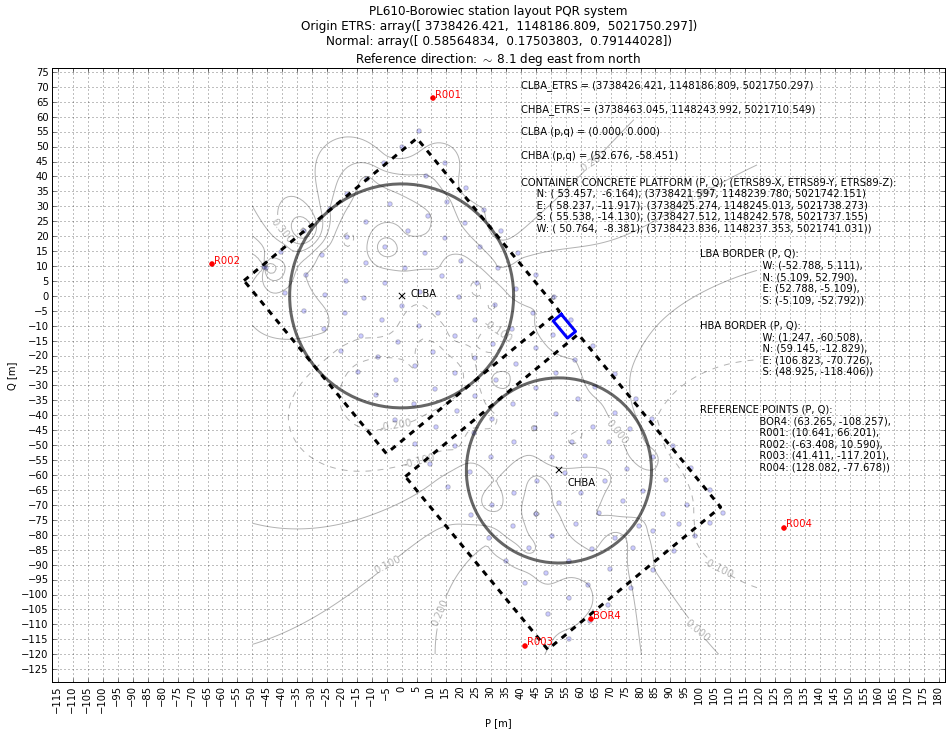

In [18]:
figure(figsize=(16, 11))
axis('equal')
grid()
cnt = contour(p_m, q_m, r_m, levels=arange(-2.0, 2.0, 0.1), colors='black', alpha=0.3)
cnt.clabel(inline=True)

xlabel('P [m]')
ylabel('Q [m]')
xticks(arange(-200, 200, 5), rotation=90)
yticks(arange(-200, 200, 5))

scatter(station_pqr[:,0], station_pqr[:,1], alpha=0.2)

lba_box_width_m = 85.0
hba_box_width_m = 72

container_pqr = transform(container_etrs, CLBA_ETRS, rotation_matrix.T)
container_pqr = concatenate([container_pqr, container_pqr[0,:].reshape((1,3))], axis=0)
lba_border_pqr = transform(field_corners_etrs[0:4,:], CLBA_ETRS, rotation_matrix.T)
lba_border_pqr =  concatenate([lba_border_pqr, lba_border_pqr[0,:].reshape((1,3))], axis=0)
hba_border_pqr = transform(field_corners_etrs[4:8,:], CLBA_ETRS, rotation_matrix.T)
hba_border_pqr =  concatenate([hba_border_pqr, hba_border_pqr[0,:].reshape((1,3))], axis=0)
reference_pqr =  transform(reference_etrs, CLBA_ETRS, rotation_matrix.T)

print(lba_border_pqr)
plot(container_pqr[:,0], container_pqr[:,1], linewidth=3)
plot(lba_border_pqr[:,0], lba_border_pqr[:,1], linewidth=3, color='black', linestyle='--')
plot(hba_border_pqr[:,0], hba_border_pqr[:,1], linewidth=3, color='black', linestyle='--')

for name, pqr in zip(reference_names, reference_pqr):
    scatter(pqr[0], pqr[1], color='red')
    text(pqr[0]+1, pqr[1]+0.5, name, color='red')

#lba_square = square_corners(lba_box_width_m, angle_rad=rot_ccw_rad)
#hba_square = square_corners(hba_box_width_m, angle_rad=rot_ccw_rad)


chba_pqr = transform([CHBA_ETRS], CLBA_ETRS, rotation_matrix.T)[0]
#plot(hba_square[:,0]+chba_pqr[0], hba_square[:,1]+chba_pqr[1], linewidth=3, alpha=0.6, color='black')
hba_circle = circle_points(HBA_CIRCLE_DIAMETER)
plot(hba_circle[:,0]+chba_pqr[0], hba_circle[:,1]+chba_pqr[1], linewidth=3, alpha=0.6, color='black')
clba_pqr = transform([CLBA_ETRS], CLBA_ETRS, rotation_matrix.T)[0]
#plot(lba_square[:,0]+clba_pqr[0], lba_square[:,1]+clba_pqr[1], linewidth=3, alpha=0.6, color='black')
lba_circle = circle_points(LBA_CIRCLE_DIAMETER)
plot(lba_circle[:,0]+clba_pqr[0], lba_circle[:,1]+clba_pqr[1], linewidth=3, alpha=0.6, color='black')

#CHBA_ETRS = solution['mean']+(transform([new_chba_pqr], zeros(3), rotation_matrix)[0,:])
#CLBA_ETRS = solution['mean']+(transform([new_clba_pqr], zeros(3), rotation_matrix)[0,:])

scatter(chba_pqr[0], chba_pqr[1], color='black', s=40, marker='x')
text(chba_pqr[0]+3, chba_pqr[1]-5, 'CHBA', color='black')
scatter(clba_pqr[0], clba_pqr[1], color='black', s=40, marker='x')
text(clba_pqr[0]+3, clba_pqr[1], 'CLBA', color='black')



title(r'''PL610-Borowiec station layout PQR system
Origin ETRS: %r
Normal: %r
Reference direction: $\sim$ 8.1 deg east from north''' %
      (CLBA_ETRS, solution['normal']))
print(clba_pqr)
print(chba_pqr)
print(chba_pqr - clba_pqr)
lh=8
line=0
text(40, 70-line*lh, 'CLBA_ETRS = (%.3f, %.3f, %.3f)' % (CLBA_ETRS[0], CLBA_ETRS[1], CLBA_ETRS[2]))
line+=1
text(40, 70-line*lh, 'CHBA_ETRS = (%.3f, %.3f, %.3f)' % (CHBA_ETRS[0], CHBA_ETRS[1], CHBA_ETRS[2]))
line+=1
text(40, 70-line*lh, 'CLBA (p,q) = (%.3f, %.3f)' % (clba_pqr[0], clba_pqr[1]))
line+=1
text(40, 70-line*lh, 'CHBA (p,q) = (%.3f, %.3f)' % (chba_pqr[0], chba_pqr[1]))

line+=3
text(40, 70-line*lh,
     '''CONTAINER CONCRETE PLATFORM (P, Q); (ETRS89-X, ETRS89-Y, ETRS89-Z):
     N: (%7.3f, %7.3f); (%.3f, %.3f, %.3f)
     E: (%7.3f, %7.3f); (%.3f, %.3f, %.3f)
     S: (%7.3f, %7.3f); (%.3f, %.3f, %.3f)
     W: (%7.3f, %7.3f); (%.3f, %.3f, %.3f))''' %
    tuple(concatenate([container_pqr[0:4,0:2], container_etrs[0:4,:]], axis=1).ravel()))
line+=3
text(100, 70-line*lh,
     '''LBA BORDER (P, Q):
                    W: (%.3f, %.3f),
                    N: (%.3f, %.3f),
                    E: (%.3f, %.3f),
                    S: (%.3f, %.3f))''' %
    tuple(lba_border_pqr[0:4,0:2].ravel()))

line+=3
text(100, 70-line*lh,
     '''HBA BORDER (P, Q):
                    W: (%.3f, %.3f),
                    N: (%.3f, %.3f),
                    E: (%.3f, %.3f),
                    S: (%.3f, %.3f))''' %
    tuple(hba_border_pqr[0:4,0:2].ravel()))
line+=4
text(100, 70-line*lh,
     '''REFERENCE POINTS (P, Q):
                   %s: (%.3f, %.3f),
                   %s: (%.3f, %.3f),
                   %s: (%.3f, %.3f),
                   %s: (%.3f, %.3f),
                   %s: (%.3f, %.3f))''' %
    reduce(lambda x, y: x+y, zip(reference_names, reference_pqr[:,0], reference_pqr[:,1])))


savefig('pl610-borowiec-station-overview-pqr-20150327.pdf')

print(transform([[+54.0, -61.0, 0.0]], array([0,0,0]), rotation_matrix)+CLBA_ETRS)
print(transform([CLBA_ETRS, CHBA_ETRS], CLBA_ETRS, rotation_matrix.T))
print('''CONTAINER (P, Q):
                    N: (%.3f, %.3f),
                    E: (%.3f, %.3f),
                    S: (%.3f, %.3f),
                    W: (%.3f, %.3f))''' % tuple(container_pqr[0:4,0:2].ravel()))

## Reference direction

The reference direction is the northern bisector of the X- and Y- dipoles. It is the second column of the rotation matrix. At LOFAR core station CS002 LBA, the reference direction coincides with true north, but elsewhere there is a slight deviation to ensure that all dipoles in LOFAR are oriented as similarly as possible. In this section, I determine the deviation between the reference direction (the "q" axis) and geographic north in the ETRS89 reference system.

In [19]:
ref_dir = rotation_matrix[:,1] 
print('Reference direction (q direction in ETRS89): ', ref_dir)

Reference direction (q direction in ETRS89):  [-0.79001898 -0.09518548  0.6056482 ]


To determine the angle between the reference direction of the station and ETRS89 north, we need to project the reference direction onto the tangent plane to the ellipsoid at the mean position of the field, and compute the normalized inner product between the "reference direction" of the local north frame and the projected reference direction.

In [20]:
tip_refdir = solution['mean']+ref_dir
projected_tip_ref_dir = transform(array([tip_refdir]), solution['mean'],
                                  local_north_projection.T)[0]
projected_tip_ref_dir[2] = 0.0
projected_tip_ref_dir = dot(local_north_projection, projected_tip_ref_dir)
projected_tip_ref_dir /= norm(projected_tip_ref_dir)

etrs_north = local_north_projection[:,1]
deviation = arccos(inner(etrs_north, projected_tip_ref_dir))

In [21]:
print ('Reference direction for PL610-Borowiec is %.4f degrees east from north.' %
       (deviation*180/pi,))

Reference direction for PL610-Borowiec is 8.1035 degrees east from north.


# Final field validation

In [22]:
final_etrs_surface_file='PL-610 Borowiec_LBA-HBA_XYZ_ETRF2000.txt'
final_surface_names, final_surface_positions_etrs=read_etrs_csv(final_etrs_surface_file, delimiter=';')

In [23]:
from numpy.linalg import lstsq

def fit_plane_discard_outliers(xyz):
    # data_model z = ax +by +c
    # M colvec(a, b, c) = colvec(z)
    # M row i = (x_i, y_i, 1.0)
    previous_good_points = len(xyz)+1
    good_points = ones(len(xyz), dtype=bool)
    while previous_good_points != sum(good_points):
        good_xyz = xyz[good_points]
        mean_position = good_xyz.mean(axis=0)
        mat = array([good_xyz[:,0]- mean_position[0],
                     good_xyz[:,1]- mean_position[1],
                     ones(len(good_xyz[:,2]))]).T
        a, b, c = lstsq(mat, good_xyz[:,2] - mean_position[2])[0]
        normal_vector = array([-a, -b, 1.0])
        normal_vector /= norm(normal_vector)
        matrix = projection_matrix(LOFAR_XYZ0_m, normal_vector)
        height_residuals = transform(xyz, mean_position, matrix.T)[:,2]
        std_heights = height_residuals.std()
        previous_good_points = sum(good_points)
        good_points = abs(height_residuals)/std_heights < 4
    return {'mean': mean_position,
            'normal': normal_vector,
            'matrix': matrix,
            'discarded' : xyz[logical_not(good_points)]}

In [24]:
final_solution = fit_plane_discard_outliers(final_surface_positions_etrs)
print(final_solution['mean'])
print(final_solution['normal'])
final_rotation_matrix = final_solution['matrix']
final_ref_dir = final_rotation_matrix[:,1] 
print('Reference direction (q direction in ETRS89): ', final_ref_dir)

tip_refdir = final_solution['mean']+final_ref_dir
projected_tip_ref_dir = transform(array([tip_refdir]), final_solution['mean'],
                                  local_north_projection.T)[0]
projected_tip_ref_dir[2] = 0.0
projected_tip_ref_dir = dot(local_north_projection, projected_tip_ref_dir)
projected_tip_ref_dir /= norm(projected_tip_ref_dir)

etrs_north = local_north_projection[:,1]
deviation = arccos(inner(etrs_north, projected_tip_ref_dir))

print ('Final reference direction for PL610-Borowiec is %.4f degrees east from north.' %
       (deviation*180/pi,))

[ 3738446.00576731  1148216.29934731  5021729.1609015 ]
[ 0.58466237  0.17967647  0.79112975]
Reference direction (q direction in ETRS89):  [-0.7901093  -0.09519637  0.60552865]
Final reference direction for PL610-Borowiec is 8.1044 degrees east from north.


In [25]:
CHBA_ETRS_FINAL = array([3738462.921, 1148243.954, 5021710.380])
CLBA_ETRS_FINAL = array([3738426.437, 1148186.814, 5021750.319])
CHBA_ETRS = CHBA_ETRS_FINAL
CLBA_ETRS = CLBA_ETRS_FINAL

In [26]:
final_surface_pqr = transform(final_surface_positions_etrs, CLBA_ETRS, final_rotation_matrix.T)
final_surface_height_m = interpolation_function(final_surface_pqr)
p_m, q_m = meshgrid(arange(-50, 120), arange(-120, 60))
r_m = final_surface_height_m(p_m, q_m, 0.0*q_m)

In [27]:
lba_stake_names, lba_stakes_etrs = read_etrs_csv('pl610-lba-stakes-etrs.csv', delimiter=';')
hba_stake_names, hba_stakes_etrs = read_etrs_csv('pl610-hba-stakes-etrs.csv', delimiter=';')

[[-52.79021672   5.10987982   0.25494198]
 [  5.10723604  52.7897289    0.27188156]
 [ 52.78691085  -5.1083294    0.25922887]
 [ -5.10985623 -52.79246059   0.24184957]
 [-52.79021672   5.10987982   0.25494198]]
[ 0.  0.  0.]
[  5.26761245e+01  -5.84500768e+01   6.04570181e-04]
[  5.26761245e+01  -5.84500768e+01   6.04570181e-04]
[[ 3738464.69162328  1148245.49285291  5021708.72121136]]
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  5.26761245e+01  -5.84500768e+01   6.04570181e-04]]
CONTAINER (P, Q):
                    N: (53.456, -6.164),
                    E: (58.237, -11.916),
                    S: (55.537, -14.129),
                    W: (50.764, -8.380))


/usr/lib/python3.4/site-packages/matplotlib/contour.py:381: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


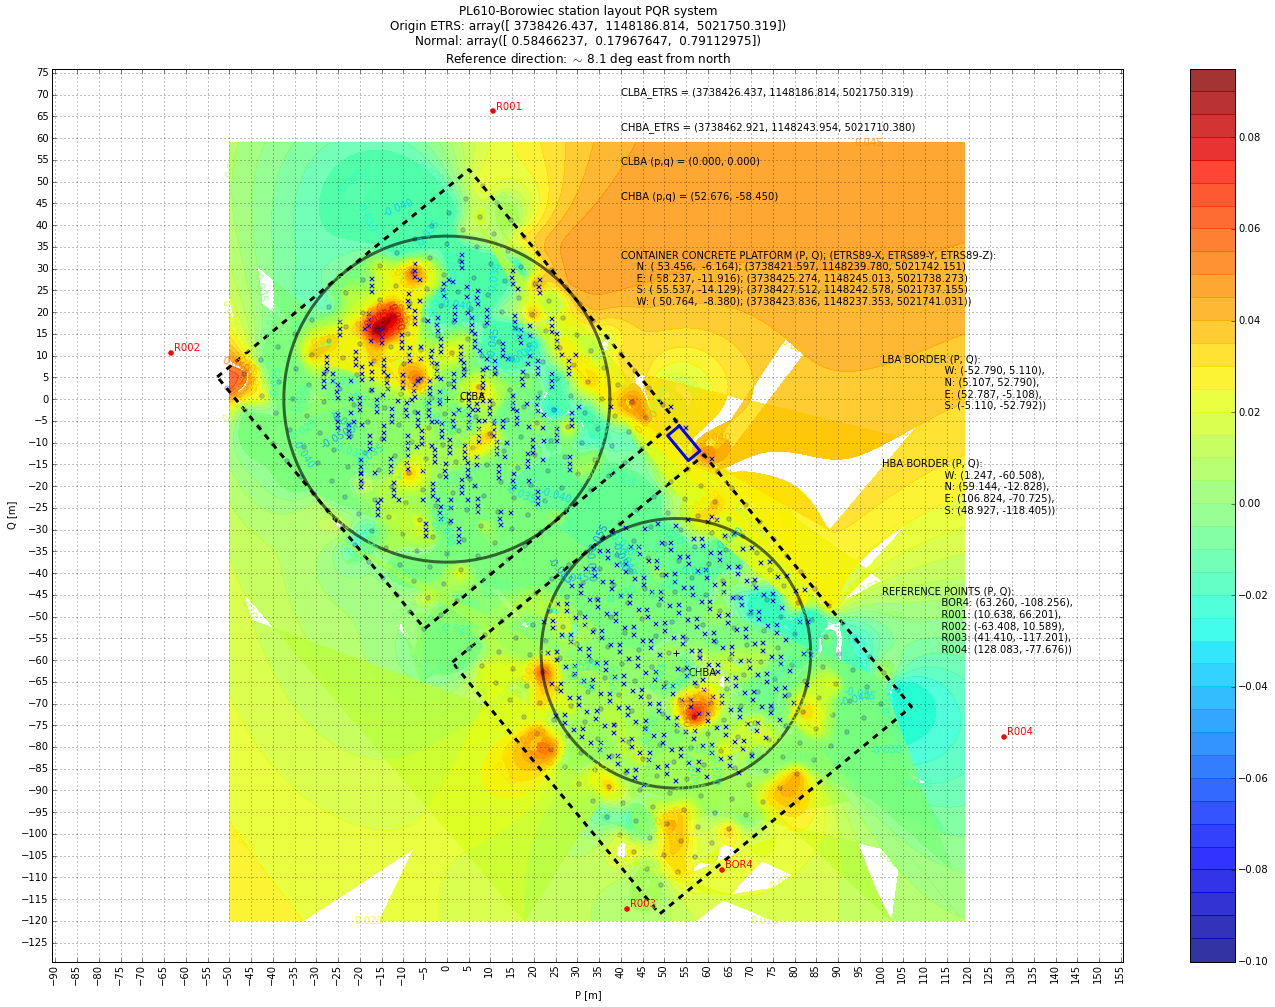

In [28]:
figure(figsize=(24, 16))
axis('equal')
grid()
cnt = contourf(p_m, q_m, r_m, levels=arange(-0.1, 0.1, 0.005), alpha=0.8)
cnt.clabel(inline=True)
colorbar()

xlabel('P [m]')
ylabel('Q [m]')
xticks(arange(-200, 200, 5), rotation=90)
yticks(arange(-200, 200, 5))

scatter(final_surface_pqr[:,0], final_surface_pqr[:,1], alpha=0.2)

lba_box_width_m = 85.0
hba_box_width_m = 72

container_pqr = transform(container_etrs, CLBA_ETRS, final_rotation_matrix.T)
container_pqr = concatenate([container_pqr, container_pqr[0,:].reshape((1,3))], axis=0)
lba_border_pqr = transform(field_corners_etrs[0:4,:], CLBA_ETRS, final_rotation_matrix.T)
lba_border_pqr =  concatenate([lba_border_pqr, lba_border_pqr[0,:].reshape((1,3))], axis=0)
hba_border_pqr = transform(field_corners_etrs[4:8,:], CLBA_ETRS, final_rotation_matrix.T)
hba_border_pqr =  concatenate([hba_border_pqr, hba_border_pqr[0,:].reshape((1,3))], axis=0)
reference_pqr =  transform(reference_etrs, CLBA_ETRS, final_rotation_matrix.T)

print(lba_border_pqr)
plot(container_pqr[:,0], container_pqr[:,1], linewidth=3)
plot(lba_border_pqr[:,0], lba_border_pqr[:,1], linewidth=3, color='black', linestyle='--')
plot(hba_border_pqr[:,0], hba_border_pqr[:,1], linewidth=3, color='black', linestyle='--')

for name, pqr in zip(reference_names, reference_pqr):
    scatter(pqr[0], pqr[1], color='red')
    text(pqr[0]+1, pqr[1]+0.5, name, color='red')

lba_stakes_pqr = transform(lba_stakes_etrs, CLBA_ETRS, final_rotation_matrix.T)
hba_stakes_pqr = transform(hba_stakes_etrs, CLBA_ETRS, final_rotation_matrix.T)
    
scatter(lba_stakes_pqr[:,0], lba_stakes_pqr[:,1], marker='x')
scatter(hba_stakes_pqr[:,0], hba_stakes_pqr[:,1], marker='x')
#lba_square = square_corners(lba_box_width_m, angle_rad=rot_ccw_rad)
#hba_square = square_corners(hba_box_width_m, angle_rad=rot_ccw_rad)


chba_pqr = transform([CHBA_ETRS], CLBA_ETRS, final_rotation_matrix.T)[0]
#plot(hba_square[:,0]+chba_pqr[0], hba_square[:,1]+chba_pqr[1], linewidth=3, alpha=0.6, color='black')
hba_circle = circle_points(HBA_CIRCLE_DIAMETER)
plot(hba_circle[:,0]+chba_pqr[0], hba_circle[:,1]+chba_pqr[1], linewidth=3, alpha=0.6, color='black')
clba_pqr = transform([CLBA_ETRS], CLBA_ETRS, final_rotation_matrix.T)[0]
#plot(lba_square[:,0]+clba_pqr[0], lba_square[:,1]+clba_pqr[1], linewidth=3, alpha=0.6, color='black')
lba_circle = circle_points(LBA_CIRCLE_DIAMETER)
plot(lba_circle[:,0]+clba_pqr[0], lba_circle[:,1]+clba_pqr[1], linewidth=3, alpha=0.6, color='black')

#CHBA_ETRS = solution['mean']+(transform([new_chba_pqr], zeros(3), rotation_matrix)[0,:])
#CLBA_ETRS = solution['mean']+(transform([new_clba_pqr], zeros(3), rotation_matrix)[0,:])

scatter(chba_pqr[0], chba_pqr[1], color='black', s=40, marker='+')
text(chba_pqr[0]+3, chba_pqr[1]-5, 'CHBA', color='black')
scatter(clba_pqr[0], clba_pqr[1], color='black', s=40, marker='+')
text(clba_pqr[0]+3, clba_pqr[1], 'CLBA', color='black')



title(r'''PL610-Borowiec station layout PQR system
Origin ETRS: %r
Normal: %r
Reference direction: $\sim$ 8.1 deg east from north''' %
      (CLBA_ETRS, final_solution['normal']))
print(clba_pqr)
print(chba_pqr)
print(chba_pqr - clba_pqr)
lh=8
line=0
text(40, 70-line*lh, 'CLBA_ETRS = (%.3f, %.3f, %.3f)' % (CLBA_ETRS[0], CLBA_ETRS[1], CLBA_ETRS[2]))
line+=1
text(40, 70-line*lh, 'CHBA_ETRS = (%.3f, %.3f, %.3f)' % (CHBA_ETRS[0], CHBA_ETRS[1], CHBA_ETRS[2]))
line+=1
text(40, 70-line*lh, 'CLBA (p,q) = (%.3f, %.3f)' % (clba_pqr[0], clba_pqr[1]))
line+=1
text(40, 70-line*lh, 'CHBA (p,q) = (%.3f, %.3f)' % (chba_pqr[0], chba_pqr[1]))

line+=3
text(40, 70-line*lh,
     '''CONTAINER CONCRETE PLATFORM (P, Q); (ETRS89-X, ETRS89-Y, ETRS89-Z):
     N: (%7.3f, %7.3f); (%.3f, %.3f, %.3f)
     E: (%7.3f, %7.3f); (%.3f, %.3f, %.3f)
     S: (%7.3f, %7.3f); (%.3f, %.3f, %.3f)
     W: (%7.3f, %7.3f); (%.3f, %.3f, %.3f))''' %
    tuple(concatenate([container_pqr[0:4,0:2], container_etrs[0:4,:]], axis=1).ravel()))
line+=3
text(100, 70-line*lh,
     '''LBA BORDER (P, Q):
                    W: (%.3f, %.3f),
                    N: (%.3f, %.3f),
                    E: (%.3f, %.3f),
                    S: (%.3f, %.3f))''' %
    tuple(lba_border_pqr[0:4,0:2].ravel()))

line+=3
text(100, 70-line*lh,
     '''HBA BORDER (P, Q):
                    W: (%.3f, %.3f),
                    N: (%.3f, %.3f),
                    E: (%.3f, %.3f),
                    S: (%.3f, %.3f))''' %
    tuple(hba_border_pqr[0:4,0:2].ravel()))
line+=4
text(100, 70-line*lh,
     '''REFERENCE POINTS (P, Q):
                   %s: (%.3f, %.3f),
                   %s: (%.3f, %.3f),
                   %s: (%.3f, %.3f),
                   %s: (%.3f, %.3f),
                   %s: (%.3f, %.3f))''' %
    reduce(lambda x, y: x+y, zip(reference_names, reference_pqr[:,0], reference_pqr[:,1])))


savefig('pl610-borowiec-station-overview-pqr-20150811.pdf')

print(transform([[+54.0, -61.0, 0.0]], array([0,0,0]), final_rotation_matrix)+CLBA_ETRS)
print(transform([CLBA_ETRS, CHBA_ETRS], CLBA_ETRS, final_rotation_matrix.T))
print('''CONTAINER (P, Q):
                    N: (%.3f, %.3f),
                    E: (%.3f, %.3f),
                    S: (%.3f, %.3f),
                    W: (%.3f, %.3f))''' % tuple(container_pqr[0:4,0:2].ravel()))

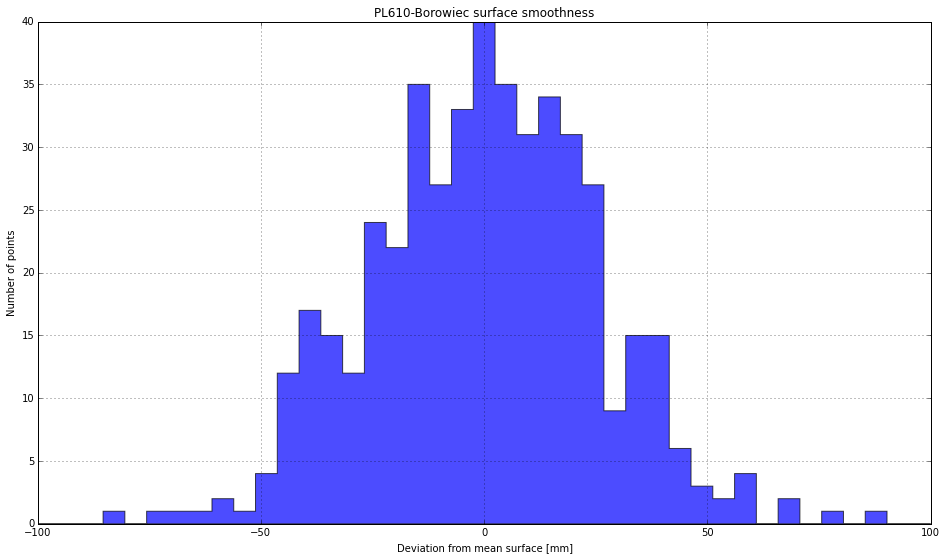

In [29]:
figure(figsize=(16,9))
_= hist(final_surface_pqr[:,2]*1000, bins=41, range=(-100, 100), histtype='stepfilled', alpha=0.7)
xlabel('Deviation from mean surface [mm]')
ylabel('Number of points')
title('PL610-Borowiec surface smoothness')
grid()

In [30]:
h = final_surface_pqr[:,2]*1000
sqrt((h**2)).mean()

20.180033224703049

In [32]:
lba_stakes_pqr_rows = [(row[0], array([float(x) for x in row[1:]]))
                       for row in csv.reader(open('pl610-lba-stakes-pqr.csv', 'r'))
                       if 'STATION-P' not in row]
hba_stakes_pqr_rows = [(row[0], array([float(x) for x in row[1:]]))
                       for row in csv.reader(open('pl610-hba-stakes-pqr.csv', 'r'))
                       if 'STATION-P' not in row]
lba_stakes_etrs = [(name, CLBA_ETRS + transform([pqr], zeros(3), rotation_matrix)[0,:])
                   for name, pqr in lba_stakes_pqr_rows]
hba_stakes_etrs = [(name, CHBA_ETRS + transform([pqr], zeros(3), rotation_matrix)[0,:])
                   for name, pqr in hba_stakes_pqr_rows]
lba_stakes_local = [(name, transform([pqr], CLBA_ETRS , local_north_projection.T)[0,:])
                   for name, pqr in lba_stakes_etrs]
hba_stakes_local = [(name, transform([pqr], CLBA_ETRS , local_north_projection.T)[0,:])
                   for name, pqr in hba_stakes_etrs]

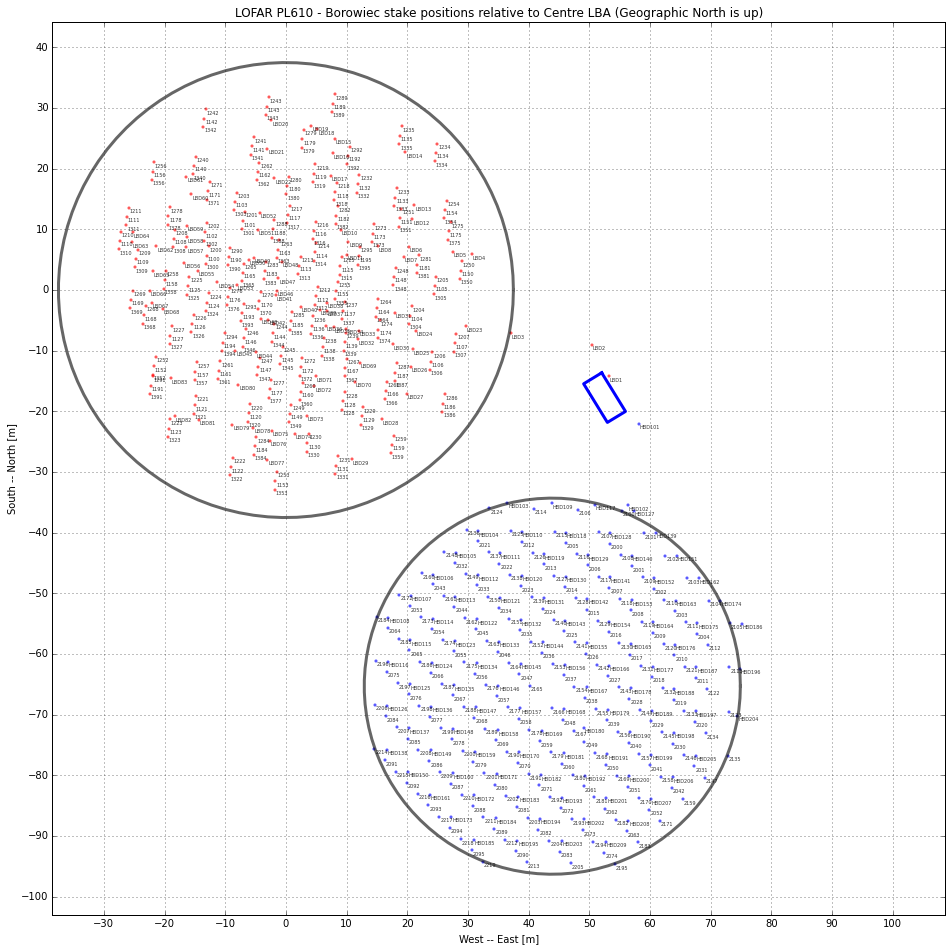

In [36]:
figure(figsize=(16,16))

for name, pqr in lba_stakes_local:
    scatter(pqr[0], pqr[1], alpha=0.5, s=5, color='red')
    text(pqr[0]+.2, pqr[1]-.2, name, fontsize=5, alpha=0.8,
         verticalalignment='top')
for name, pqr in hba_stakes_local:
    scatter(pqr[0], pqr[1], alpha=0.5, s=5, color='blue')
    text(pqr[0]+.2, pqr[1]-.2, name, fontsize=5, alpha=0.8,
         verticalalignment='top')
container_local = transform(container_etrs, CLBA_ETRS, local_north_projection.T)
container_local = concatenate([container_local, container_local[0,:].reshape((1,3))], axis=0)

plot(container_local[:,0], container_local[:,1], linewidth=3)


chba_local = transform([CHBA_ETRS], CLBA_ETRS, local_north_projection.T)[0]
hba_circle = circle_points(HBA_CIRCLE_DIAMETER)
plot(hba_circle[:,0]+chba_local[0], hba_circle[:,1]+chba_local[1], linewidth=3, alpha=0.6, color='black')
clba_local = transform([CLBA_ETRS], CLBA_ETRS, local_north_projection.T)[0]
lba_circle = circle_points(LBA_CIRCLE_DIAMETER)
plot(lba_circle[:,0]+clba_local[0], lba_circle[:,1]+clba_local[1], linewidth=3, alpha=0.6, color='black')


xticks(arange(-150,170,10))
yticks(arange(-150, 80,10))
axis('equal')
grid()
xlim(-50,120)
xlabel('West -- East [m]')
ylabel('South -- North [m]')
title('LOFAR PL610 - Borowiec stake positions relative to Centre LBA (Geographic North is up)')
savefig('pl610-stake-positions.pdf')